In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1."
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.devices()

In [2]:
import jax
import optax

import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi
from momi3.utils import bootstrap_sample

import re
import math
import pickle
import tskit

from tqdm.notebook import tqdm, trange

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp

from ast import literal_eval

from train import get_demo, get_params

/mnt/turbo/eneswork/jthlab/momi3/src/momi3/utils.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [80]:
demo = demes.load('../timing_tests_yaml/3_pop_mig.yaml')

In [83]:
momi = Momi(demo, ['CEU', 'CHB', 'YRI'], [5,5,5], jitted=True)

In [86]:
jsfs = momi.simulate_chromosome(1e8, 1e-8, 1e-8)

In [88]:
params = momi._default_params

In [89]:
params.set_train_all_rhos(True)

In [92]:
%%time
momi.loglik_with_gradient(params, jsfs)

CPU times: user 324 ms, sys: 11.6 ms, total: 335 ms
Wall time: 327 ms


(-208869.40625,
 {'rho_0': -7467103.5, 'rho_1': -24795130.0, 'rho_2': -1517394.25})

In [96]:
ts.node(7508)

Node(id=7508, flags=1048577, time=184.56, population=210, individual=3754, metadata=b'')

In [74]:
ts = tskit.load('../../../Unified_genome/hgdp_tgp_sgdp_high_cov_ancients_chr20_p.dated.trees')

In [75]:
list(ts.populations())

[Population(id=0, metadata=b'{"name": "Adygei", "region": "EUROPE"}'),
 Population(id=1, metadata=b'{"name": "Balochi", "region": "CENTRAL_SOUTH_ASIA"}'),
 Population(id=2, metadata=b'{"name": "BantuKenya", "region": "AFRICA"}'),
 Population(id=3, metadata=b'{"name": "BantuSouthAfrica", "region": "AFRICA"}'),
 Population(id=4, metadata=b'{"name": "Basque", "region": "EUROPE"}'),
 Population(id=5, metadata=b'{"name": "Bedouin", "region": "MIDDLE_EAST"}'),
 Population(id=6, metadata=b'{"name": "BergamoItalian", "region": "EUROPE"}'),
 Population(id=7, metadata=b'{"name": "Biaka", "region": "AFRICA"}'),
 Population(id=8, metadata=b'{"name": "Bougainville", "region": "OCEANIA"}'),
 Population(id=9, metadata=b'{"name": "Brahui", "region": "CENTRAL_SOUTH_ASIA"}'),
 Population(id=10, metadata=b'{"name": "Burusho", "region": "CENTRAL_SOUTH_ASIA"}'),
 Population(id=11, metadata=b'{"name": "Cambodian", "region": "EAST_ASIA"}'),
 Population(id=12, metadata=b'{"name": "Colombian", "region": "AMERI

In [79]:
ts.samples(210)

array([7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515], dtype=int32)

In [70]:
jsfs = np.load('jsfs_UNIF_chr20_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108.npy')

In [71]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [i - 1 for i in jsfs.shape]

In [72]:
sample_sizes

[214, 56, 30, 2, 2]

In [6]:
print('sample sizes')
for i, j in zip(sampled_demes, sample_sizes):
    print(f"{i}: {j}")

sample sizes
Yoruba: 214
French: 56
Papuan: 30
Vindija: 2
Denisovan: 2


In [7]:
print(f'# Number of SNPs: {jsfs.sum()/1e6:.1f} million')

# Number of SNPs: 0.9 million


In [8]:
print(f'# Non-zero SFS entries: {(jsfs != 0).sum()/1e6:.2f} million')

# Non-zero SFS entries: 0.03 million


In [56]:
demo = demes.load('arc5_pulse_inferred.yaml')

In [57]:
dd = demo.asdict()

In [58]:
b = demes.Builder.fromdict(dd)

In [59]:
b.add_migration(source='DenisovanGHOST', dest='NeanderthalGHOST', rate=0.001, end_time=3000)
b.add_migration(source='NeanderthalGHOST', dest='DenisovanGHOST', rate=0.002, end_time=3000)

In [60]:
demo = b.resolve()

<AxesSubplot:ylabel='time ago (generations)'>

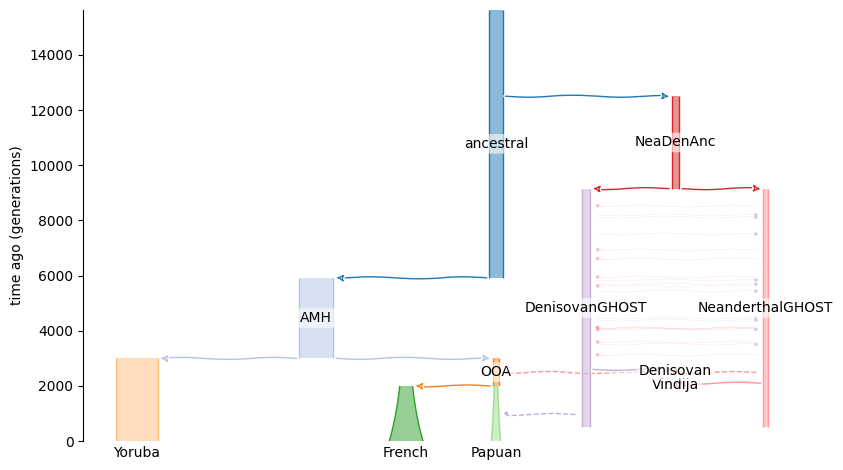

In [61]:
demesdraw.tubes(demo)

In [62]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True)

In [63]:
params = Params(momi)

In [64]:
bounds = momi.bound_sampler(params, 10000, min_lineages=4, quantile=0.99)
momi = momi.bound(bounds)

In [65]:
bs_jsfs = momi._bootstrap_sample(jsfs, 10000, seed=108)

In [66]:
(bs_jsfs != 0).sum()

871

In [67]:
params.set_train_all_rhos('True')

In [ ]:
ts.p

In [69]:
%%time
momi.loglik_with_gradient(params, bs_jsfs)

CPU times: user 3min 44s, sys: 58.8 ms, total: 3min 44s
Wall time: 3min 44s


(-17510.046875, {'rho_0': 13402.044921875, 'rho_1': -10421.8916015625})

In [33]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108.npy')

In [54]:
x = bootstrap_sample(jsfs, 400000, seed=109)

In [55]:
x

Format,coo
Data Type,int64
Shape,"(215, 57, 31, 3, 3)"
nnz,22088
Density,0.006460094555802693
Read-only,True
Size,1.0M
Storage ratio,0.0


In [64]:
params.set_train_all_pis(False)
params.set_train_all_rhos(True)
params.set_train_all_etas(False)

In [65]:
%%time
momi.loglik(params, x)

CPU times: user 44.8 s, sys: 159 ms, total: 45 s
Wall time: 35.1 s


-703929.75

In [69]:
%%time
momi.loglik_with_gradient(params, x)

StoreException: Store occupied